### Import Libraries

In [1]:
from util_comp import *

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.inspection import PartialDependenceDisplay # display partial dependence plots
from sklearn.inspection import partial_dependence # calculate partial dependence

from sklearn.metrics import accuracy_score, confusion_matrix

# Ignore warnings
warnings.filterwarnings('ignore')

# Makes sure we see all columns
pd.set_option('display.max_columns', None)

### Load (Processed) Data

In [2]:
data = main(retained=True, string_issue=True)

Elapsed time to compute age categorisation: 0 minutes and 0 seconds
Elapsed time to compute correct systematic error: 0 minutes and 14 seconds
Elapsed time to compute load column names: 0 minutes and 0 seconds
Elapsed time to compute clean data: 0 minutes and 0 seconds
Elapsed time to compute categorisation of outcome column: 0 minutes and 4 seconds
Elapsed time to compute change values > opt: 1 minutes and 43 seconds
Elapsed time to compute Full process: 2 minutes and 2 seconds


In [3]:
data.head()

,YEAR MMS,Q1- Your sex?,Q2- How old are you?,STATUS,In which sector of activity do you work?,"What is the size of your business (in total, all locations combined)? 2009 fake","Q4- (3 to 6 years old) In each of the following age groups, how many children live totally or partially with you?","Q4- (7 to 12 years old) In each of the following age groups, how many children live totally or partially with you?","Q4- (13 to 17 years old) In each of the following age groups, how many children live totally or partially with you?","Q4- (18 years and over) In each of the following age groups, how many children live totally or partially with you?","Q5- Apart from your children, do you have a dependent or sick family member(s) whom you take care of regularly?","Would you say that over the last 12 months, your company's activity has:",Q9- Are you working?,"Q10- Do you have shift work (work organized in successive teams, which take turns at the same workstations) with alternating hours?",Q12- Do you work most often?,Q13- Is the performance of your work taxing on you?-To remain standing for a long time or in an awkward posture,Q13- Is the performance of your work taxing on you?-To carry or move heavy loads,Q13- Is the performance of your work taxing on you?-To perform repetitive gestures,Q13- Is the performance of your work taxing on you?-To work on screen,Q13- Is the performance of your work taxing on you?-Working in the cold / in the heat,Q13- Is the performance of your work taxing on you?-To work in noise,"Q14- During your work, are you in a situation? (Of-breathe toxic products or dust","Q14- During your work, are you in a situation? (Of-handle toxic or dangerous products","Q14- During your work, are you in a situation? (Of-risk a serious fall","Q14- During your work, are you in a situation? (Of-working on machinery that could expose you to injury",Q15- Indicate whether each of the following sentences suits you-My work allows me to learn new things,Q15- Indicate whether each of the following sentences suits you-My job requires working very quickly or very intensely,Q15- Indicate whether each of the following sentences suits you-My job requires long periods of concentration,Q15- Indicate whether each of the following sentences suits you-My job is physically tiring,Q15- Indicate whether each of the following sentences suits you-My work is nervously tiring,Q15- Indicate whether each of the following sentences suits you-I am satisfied with my work,Q15- Indicate whether each of the following sentences suits you-In my job I have the opportunity to make decisions,"Q15- Indicate whether each of the following sentences suits you-At times, I have difficulty managing priorities",Q15- Indicate whether each of the following sentences suits you-I feel recognized by my hierarchy,Q15- Indicate whether each of the following sentences suits you-I have the opportunity to develop my professional skills,Q15- Indicate whether each of the following sentences suits you-There is good understanding where I work,Q15- Indicate whether each of the following sentences suits you-I have a well-suited workstation,Q15- Indicate whether each of the following sentences suits you-I systematically seek to improve the way I work,Q15- Indicate whether each of the following sentences suits you-My company takes care of the well-being of its employees,Q15- Indicate whether each of the following sentences suits you-Security is a priority for my business,"Q15- Indicate whether each of the following sentences suits you-In the event of a problem, I can count on my supervisor","Would you say that over the last 12 months, your pace of work has:",Q16- And for each of these sentences?-I would recommend my company to a friend,Q16- And for each of these sentences?-I am proud to work in my company,"Q17- At work, does it happen to you: (D-have decreased alertness, lack of attention","Q17- At work, does it happen to you: (D-e receiving hurtful or aggressive remarks within the company","Q17- At 

### Train

In [4]:
# data = df

# Split the data for training and evaluation

X = data[(data['outcome'] == 2) | (data['outcome'] == 3)].drop('outcome', axis=1, inplace=False)
X.columns = [str(col) for col in X.columns]
y = data[(data['outcome'] == 2) | (data['outcome'] == 3)]['outcome']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [5]:
# Train a random forest regressor model
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

# Get predictions
y_pred = rf.predict(X_test)

# # Calculate the accuracy
# accuracy = rf.score(X_test, y_test)
# print(f"Test Accuracy: {accuracy}") # Accuracy in rf.score ranges from -inf to 1. 1 is the best

# Calculate the accuracy_score
y_pred = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}") # Accuracy in accuracy_score ranges from 0 to 1. 1 is the best

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion matrix:\n{cm}") # 2x2 matrix with the following structure:
# [[TN, FP]
#  [FN, TP]]

# Calculate the feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    if f > 20:
        break
    print(f"{f+1}. feature {indices[f]} ({importances[indices[f]]})")

Accuracy: 0.6659825551564905
Confusion matrix:
[[ 262  456]
 [ 195 1036]]
Feature ranking:
1. feature 2 (0.023857465010116444)
2. feature 64 (0.022058288576283464)
3. feature 14 (0.021953623148234982)
4. feature 82 (0.021381057383228)
5. feature 4 (0.020041468304676794)
6. feature 91 (0.019480374020334597)
7. feature 79 (0.018439338195863776)
8. feature 81 (0.01840344703518234)
9. feature 92 (0.018377334677997893)
10. feature 84 (0.017648596449197446)
11. feature 93 (0.01741585594973033)
12. feature 86 (0.016103219202754655)
13. feature 87 (0.015459302916453648)
14. feature 18 (0.014682150629903435)
15. feature 78 (0.014463860603642383)
16. feature 97 (0.01421099315380923)
17. feature 88 (0.014022290344858877)
18. feature 32 (0.013502553930405378)
19. feature 20 (0.013274021226977174)
20. feature 16 (0.013178594630876008)
21. feature 5 (0.013003373464869248)


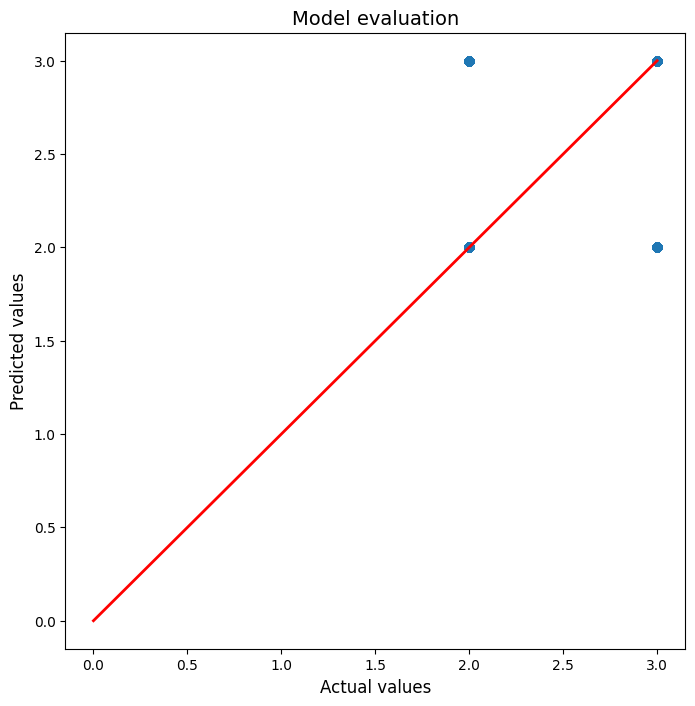

In [6]:
# Model evaluation
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

plt.scatter(y_test, y_pred)
plt.plot([0, 3], [0, 3], color='r', linestyle='-', linewidth=2)

plt.xlabel('Actual values', size=12)
plt.ylabel('Predicted values', size=12)
plt.title('Model evaluation', size=14)
plt.savefig('outputs/03_23_ice_pdp/model_evaluation.png')
plt.show()

In [7]:
X_train.columns[2]

'Q2- How old are you?'

In [8]:
pdp_lines = partial_dependence(
    rf,
    X_train,
    features=[X_train.columns[2]],
    percentiles=(0, 1),
    grid_resolution=100,
    kind='individual'
)
len(pdp_lines['individual'][0])

7795

In [9]:
pdp_lines

{'grid_values': [array([ 1.,  2.,  3.,  4.,  5.,  6., nan])],
 'individual': array([[[2.88, 2.91, 2.89, ..., 2.9 , 2.9 , 2.9 ],
         [2.3 , 2.26, 2.21, ..., 2.25, 2.25, 2.31],
         [2.78, 2.8 , 2.82, ..., 2.82, 2.82, 2.8 ],
         ...,
         [2.33, 2.28, 2.27, ..., 2.25, 2.22, 2.29],
         [2.75, 2.79, 2.75, ..., 2.71, 2.72, 2.76],
         [2.83, 2.86, 2.88, ..., 2.9 , 2.86, 2.87]]])}

In [10]:
print(np.shape(pdp_lines['grid_values']))
print(np.shape(pdp_lines['individual']))

(1, 7)
(1, 7795, 7)


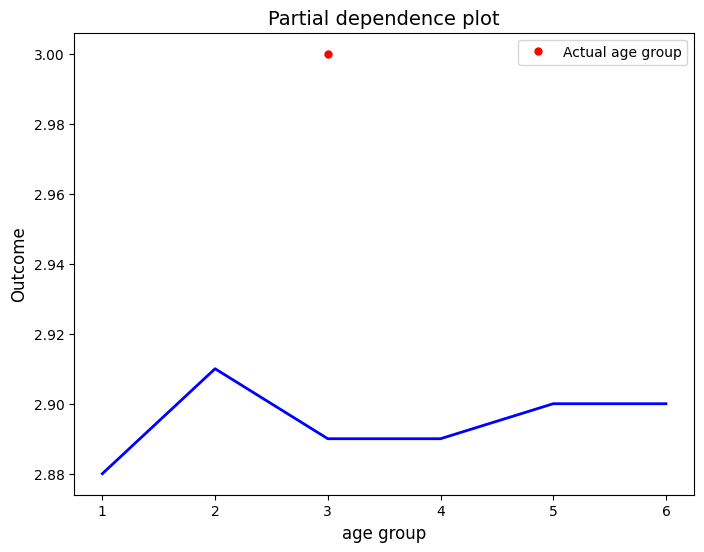

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(pdp_lines['grid_values'][0], pdp_lines['individual'][0][0], color='b', linewidth=2)

per_0 = data.iloc[0]
plt.plot(per_0[5], y_pred[0], 'ro', markersize=5, label='Actual age group')

plt.xlabel('age group', size=12)
plt.ylabel('Outcome', size=12)
plt.legend()
plt.title('Partial dependence plot', size=14)
plt.savefig('outputs/03_23_ice_pdp/pdp.png')
plt.show()

In [12]:
X_train.columns[2]  

'Q2- How old are you?'

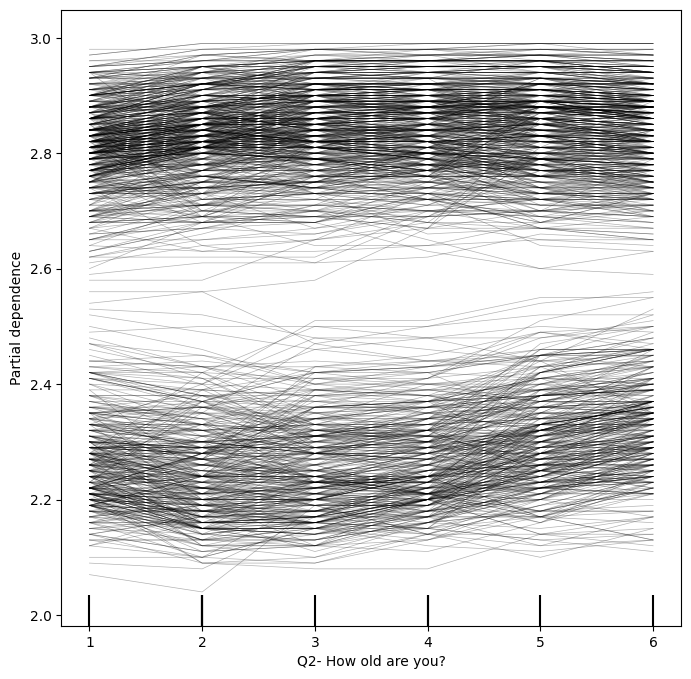

In [13]:
# ICE plot

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
PartialDependenceDisplay.from_estimator(rf, X_train, features=[X_train.columns[2]], 
                                        kind='individual',
                                        ice_lines_kw={"color":"black"},
                                        ax=ax)
plt.savefig('outputs/03_23_ice_pdp/ice_plot.png')
plt.show()

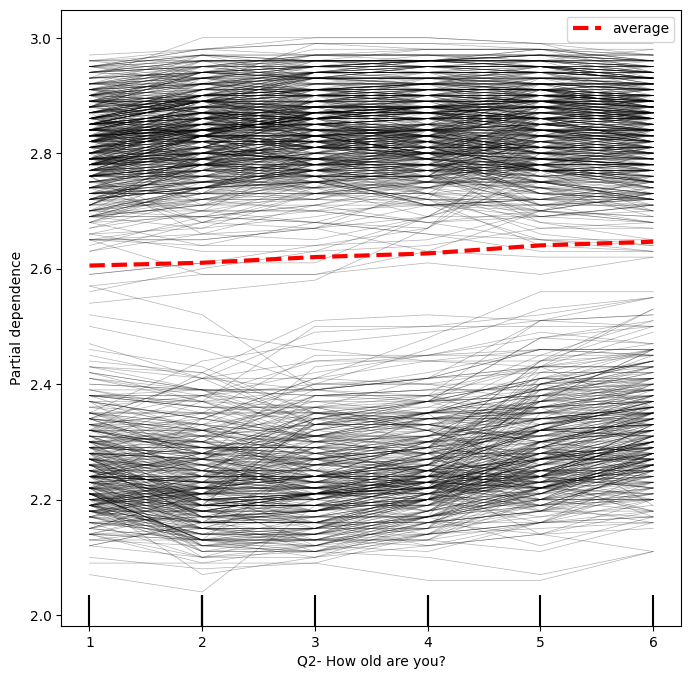

In [14]:
# ICE plot and PDP plot

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
PartialDependenceDisplay.from_estimator(rf, X_train, features=[X_train.columns[2]], 
                                        kind='both',
                                        ice_lines_kw={"color":"black"},
                                        pd_line_kw={"color":"red","lw":3, "linestyle":"--"},
                                        ax=ax)
plt.savefig('outputs/03_23_ice_pdp/ice_pdp_plot.png')
plt.show()

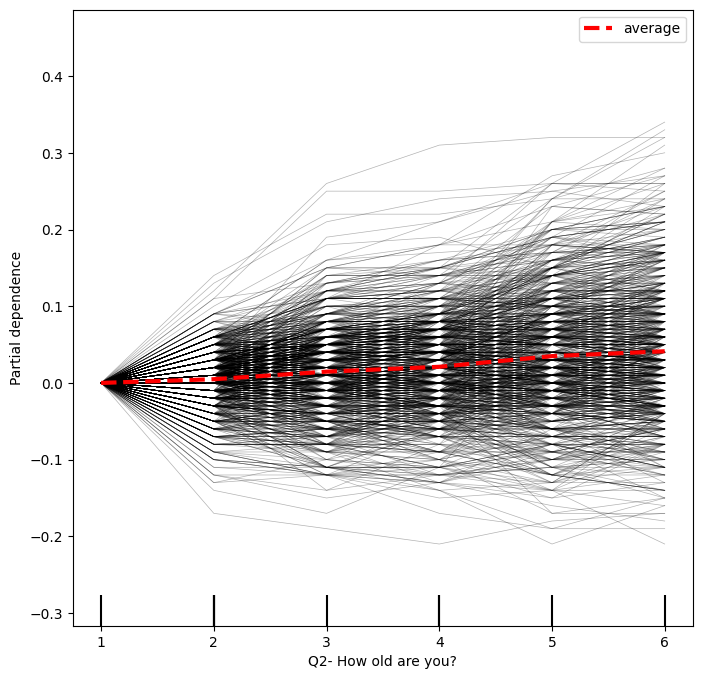

In [15]:
# ICE and PDP plot centered

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
PartialDependenceDisplay.from_estimator(rf, X_train, features=[X_train.columns[2]], 
                                        kind='both',
                                        centered=True,
                                        ice_lines_kw={"color":"black"},
                                        pd_line_kw={"color":"red","lw":3, "linestyle":"--"},
                                        ax=ax)
plt.savefig('outputs/03_23_ice_pdp/ice_pdp_plot_centered.png')
plt.show()

In [16]:
# manual center the lines

for i in range(len(pdp_lines['individual'][0])):
    pdp_start = pdp_lines['individual'][0][i][0]
    for j in range(len(pdp_lines['individual'][0][i])):
        pdp_lines['individual'][0][i][j] = pdp_lines['individual'][0][i][j] - pdp_start

(7795, 7)


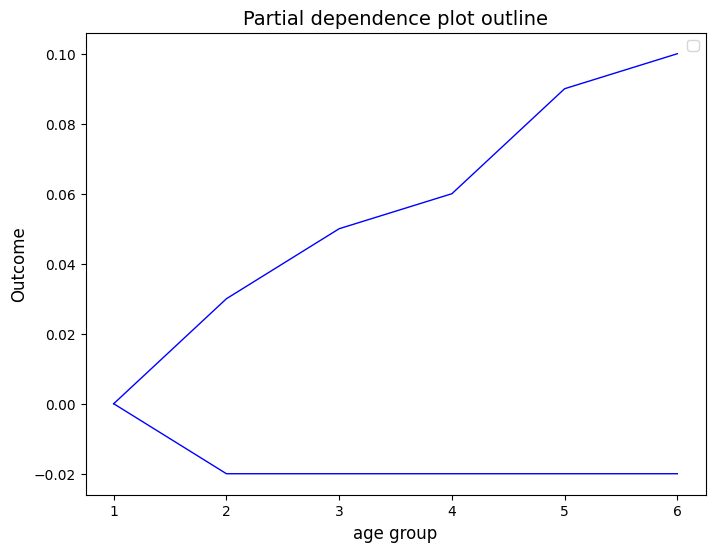

In [17]:
# get all the values that are positive and negative in each category of the feature and calculate the mean of the positive and negative values for each category of the feature and plot them

pdp_values = pdp_lines['individual'][0]
pdp_values = np.array(pdp_values)
print(pdp_values.shape)

q1 = []
q3 = []

for i in range(0,7):

    all_val = []

    for j in range(len(pdp_values)):
        all_val.append(pdp_values[j][i])
    
    iqr = stats.iqr(all_val)
    q1x = np.percentile(all_val, 25)
    q3x = np.percentile(all_val, 75)

    q1.append(q1x)
    q3.append(q3x)



plt.figure(figsize=(8, 6))
plt.plot(pdp_lines['grid_values'][0], q1, color='b', linewidth=1)
plt.plot(pdp_lines['grid_values'][0], q3, color='b', linewidth=1)

plt.xlabel('age group', size=12)
plt.ylabel('Outcome', size=12)
plt.legend()
plt.title('Partial dependence plot outline', size=14)
plt.savefig('outputs/03_23_ice_pdp/pdp_outline.png')
plt.show()
